### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import yaml
from random import randint as randint
sys.path.insert(0,'/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/')
from Misc.utils import *
sys.path.insert(0, '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Classifier')
import datasets

### Support Functions

In [2]:
class expand_greyscale(object):
    def __init__(self):
        self.num_target_channels = 3
    def __call__(self, tensor):
        channels = tensor.shape[0]        
        if channels == self.num_target_channels:
            return tensor
        elif channels == 1:
            color = tensor.expand(3, -1, -1)
            return color

class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

### Create Data Splits

In [ ]:
# create data splits

data_file = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Data/skin.csv'
column_name_split = 'test_train'
new_col = 'val_train_test'
test_id = 2
save_path = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Data/temp/skin2.csv'

create_data_splits(data_file, column_name_split, new_col, test_id, save_path)

### Corrupt Data using Corruption Matrix C

In [ ]:
"""
    description: Corrupt the labels of a csv data file with noise.

    assumptions: we assume all columns in data_file corresponding to class_names have 0 or 1 values only!

    info:
    data_file: path to csv file
    class_names: list of class names (pathologies)
    multi_class: (Boolean) True if multi_class, False if multi_label
    noise_level: fraction (0.0 to 1.0)
    save_path: final path including name of csv file to save
"""

# user hyperparams
config_path = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Configs/Classifier/DenseNet_MNIST.yaml'
s = 0.3
save_path = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Data/ln_cmat/dirty_mnist/train_s0p3.csv'
config = yaml.safe_load(open(config_path))
data_file = config['data_file']


class_names = config['class_names'].split(",")
corrupt_labels_via_cmat(data_file, class_names, s, save_path)

### Corrupt Data with Label Noise

In [ ]:
"""
    description: Corrupt the labels of a csv data file with noise.

    assumptions: we assume all columns in data_file corresponding to class_names have 0 or 1 values only!

    info:
    data_file: path to csv file
    class_names: list of class names (pathologies)
    multi_class: (Boolean) True if multi_class, False if multi_label
    noise_level: fraction (0.0 to 1.0)
    save_path: final path including name of csv file to save
"""

# user hyperparams
config_path = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Configs/Classifier/DenseNet_Skin.yaml'
noise_level = 0.50
save_path = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Data/skin_ln0p50.csv'

config = yaml.safe_load(open(config_path))
data_file = config['data_file']
class_names = config['class_names'].split(",")
multi_class = config['multi_class']

# corrupt_labels(data_file, class_names, multi_class, noise_level, save_path)





In [ ]:
run Train_Classifier_DenseNet.py --config '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Configs/Classifier/ln_cmat/afhq/s1p0.yaml'

### Get Model Predictions

In [ ]:
# user hyperparams
config_path = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Configs/Classifier/DenseNet_Skin_ln0p50.yaml'
merge_crit = 'image_id'
save_path = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Data/temp/skin_ln0p50_preds.csv'
clf_ckpt = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Output/HAM/Classifier_Seed_0_Dropout_0.0_LS_False_MU_False_FL_False_skin_ln0p50/HAM-densenet169-HAM_256-best-auc0.5388.pt'

config = yaml.safe_load(open(config_path)) 
config['class_names'] = config['class_names'].split(',')

dataset = fetch_dataset(config_path)
model = torch.load(clf_ckpt)
result = get_model_preds(model, dataset, config['data_file'], config['class_names'], merge_crit, save_path)

### Create CSV File for Uniformly Distributed Preds

In [ ]:
# user hyperparams
data_file = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Data/skin_ln0p50_preds.csv'
col_name = 'nv_preds'
num_samples = 1000

df_final = get_uniform_preds(data_file, col_name, num_samples)

In [ ]:
plt.hist(df_final[col_name]), len(df_final)

In [ ]:
# df_final.to_csv('/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Data/skin_ln0p50_uniform.csv',index=False)

### Seaborn Plots

In [ ]:
sns.set(font_scale=1.25)

# plt.figure(figsize=(7,7))
ax = sns.lineplot([0,0.1,0.2,0.3,0.4,0.5],[0.83,0.74,0.52,0.52,0.28,0.25],marker='p',label='acc')
ax = sns.lineplot([0.3,0.4,0.5],[0.78,0.68,0.42],marker='p',label='new_acc')

# ax = sns.lineplot([0,0.1,0.2,0.3,0.4,0.5],[0.88,0.85,0.86,0.86,0.76,0.45],marker='p',label='auc')
# ax = sns.lineplot([0.3,0.4,0.5],[0.79,0.75,0.5],marker='p',label='new_auc')

ax.set_yticks([0.0,0.5,1.0])
ax.set(title='Effect of Label Noise on Test Accuracy [Skin]')
plt.ylabel('Test Accuracy')
plt.xlabel('Noise Level')

[Text(0, 0, 'AiD'),
 Text(1, 0, 'NOOD'),
 Text(2, 0, 'FOOD1'),
 Text(3, 0, 'FOOD2')]

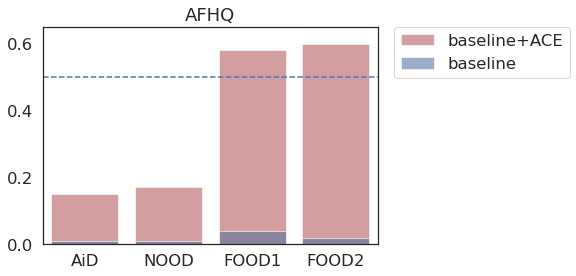

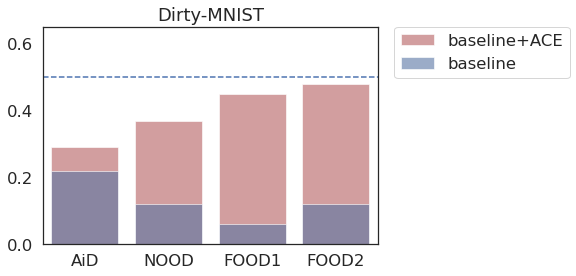

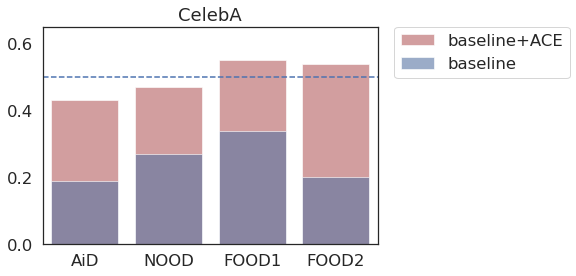

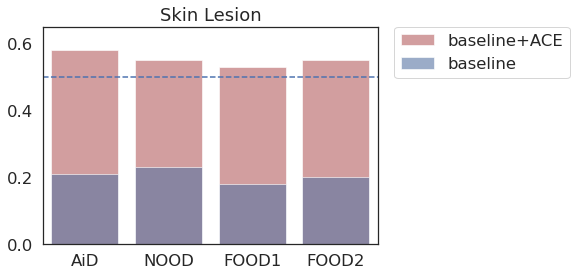

In [5]:
sns.set(font_scale=1.5)
sns.set_style("white")

ax = plt.subplots()
ax = sns.barplot(x=[1,2,3,4], y=[0.15,0.17,0.58,0.6], color='r', alpha=0.6, label='baseline+ACE')
ax = sns.barplot(x=[1,2,3,4], y=[0.01,0.01,0.04,0.02], color='b', alpha=0.6, label='baseline')
ax.axhline(0.5,linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,0.65)
plt.title('AFHQ')
ax.set_xticklabels(['AiD','NOOD','FOOD1','FOOD2'])

ax = plt.subplots()
ax = sns.barplot(x=[1,2,3,4], y=[0.29,0.37,0.45,0.48], color='r', alpha=0.6, label='baseline+ACE')
ax = sns.barplot(x=[1,2,3,4], y=[0.22,0.12,0.06,0.12], color='b', alpha=0.6, label='baseline')
ax.axhline(0.5,linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,0.65)
plt.title('Dirty-MNIST')
ax.set_xticklabels(['AiD','NOOD','FOOD1','FOOD2'])

ax = plt.subplots()
ax = sns.barplot(x=[1,2,3,4], y=[0.43,0.47,0.55,0.54], color='r', alpha=0.6, label='baseline+ACE')
ax = sns.barplot(x=[1,2,3,4], y=[0.19,0.27,0.34,0.2], color='b', alpha=0.6, label='baseline')
ax.axhline(0.5,linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,0.65)
plt.title('CelebA')
ax.set_xticklabels(['AiD','NOOD','FOOD1','FOOD2'])

ax = plt.subplots()
ax = sns.barplot(x=[1,2,3,4], y=[0.58,0.55,0.53,0.55], color='r', alpha=0.6, label='baseline+ACE')
ax = sns.barplot(x=[1,2,3,4], y=[0.21,0.23,0.18,0.2], color='b', alpha=0.6, label='baseline')
ax.axhline(0.5,linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,0.65)
plt.title('Skin Lesion')
ax.set_xticklabels(['AiD','NOOD','FOOD1','FOOD2'])

### Compute Predictive Entropy

In [ ]:
# user hyperparams
config_path = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Configs/Classifier/DenseNet_AFHQ.yaml'
clf_ckpt = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Output/AFHQ/Classifier_Seed_1234_Dropout_0.5_LS_False_MU_False_FL_False_afhq/AFHQ-densenet169-AFHQ_256-best-auc0.9999.pt'
save_path = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Data/uncerts/afhq.csv'
attrs = [0,1]   # indices to consider (from the classifier output)

config = yaml.safe_load(open(config_path)) 
config['class_names'] = config['class_names'].split(',')

dataset = fetch_dataset(config)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=512,
    shuffle=False
)
 
classifier = torch.load(clf_ckpt)

all_mc_mean_preds = np.empty([0])
with torch.no_grad():
    for batch_idx, samples in enumerate(tqdm(loader)):

        requires_grad(classifier, False)

        # sample some images and their labels
        real_imgs = samples['img']
        labels = samples['lab']
        real_imgs = real_imgs.to("cuda")
        
        # get 20 predictions for each image
        mc_preds = torch.empty(0)
        
        for i in tqdm(range(20)):
            preds = classifier(real_imgs)
            preds = torch.sigmoid(preds)
            preds = preds[:,attrs]
            preds = preds.unsqueeze(-1)
            mc_preds = torch.cat((mc_preds,preds.detach().cpu()),dim=2)
        mc_mean_preds = torch.mean(mc_preds,dim=2)

        if all_mc_mean_preds.shape[0] == 0:
            all_mc_mean_preds = np.asarray(mc_mean_preds)
        else:
            all_mc_mean_preds = np.append(all_mc_mean_preds, np.asarray(mc_mean_preds), axis=0)
        # if batch_idx==1:
        #     break
        
pred_entr = np.sum(-1*(all_mc_mean_preds * np.log2(all_mc_mean_preds)),1)


df = pd.read_csv(config['data_file'])
df['predictive_entropy'] = pred_entr
df.to_csv(save_path,index=False)

### Test Clf

In [ ]:
# just modify the ckpt path in DenseNet_AFHQ_test.yaml file and run below command

In [ ]:
run /jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Test_Classifier_DenseNet.py --config Configs/Classifier/DenseNet_AFHQ_test.yaml

### Get Augmented Data from Trained StyleGan2

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(0,"/ocean/projects/asc170022p/nmurali/projects/CounterfactualExplainer/MIMICCX-Chest-Explainer/Classifier/torchxrayvision_")
import inspect
import random
import pickle
from tqdm import tqdm
from skimage.io import imread, imsave
import torchxrayvision as xrv
import torchvision
from torchvision import datasets
from torch.utils import data
import torch
from torch.utils.data import Dataset
sys.path.insert(0,"/ocean/projects/asc170022p/nmurali/projects/CounterfactualExplainer/MIMICCX-Chest-Explainer/stylegan2Pytorch")
from swagan_updatedEGC import Generator, Discriminator
sys.path.insert(0, '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Classifier/')
import datasets

In [ ]:
# user hyperparams
dataset = 'AFHQ'

In [ ]:
seed = 1234
print(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  


if dataset == 'AFHQ':
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),\
        torchvision.transforms.Resize((256, 256)), 
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.ToTensor()
    ])
    data_file = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Data/afhq.csv'
    class_names = ['cat','dog']
    dataset = datasets.AFHQ_Dataset(csvpath=data_file, class_names=class_names, transform=transforms, seed=seed)

main_dir = '/ocean/projects/asc170022p/nmurali/projects/CounterfactualExplainer/MIMICCX-Chest-Explainer/experiments/sumedha_code/data/'

cls_final_path_mc = os.path.join(main_dir, 'clf_mc.pt')
cls_final_path = os.path.join(main_dir, 'clf267123.pt')
gan_dir = os.path.join(main_dir, 'gan267123.pt')

num_cls = 2
batch_size =2
device = "cuda"
pathologies = ['Young', 'Smiling']
concate_size = 0
img_size = 256
save_dir = os.path.join(main_dir, 'da3/')
data_dir_DA = os.path.join(save_dir, 'augmented_data')
if not os.path.exists(data_dir_DA):
    os.makedirs(data_dir_DA)
data_dir_Amb = os.path.join(save_dir, 'amb_data')
if not os.path.exists(data_dir_Amb):
    os.makedirs(data_dir_Amb)
data_dir_save = os.path.join(save_dir, 'save')
if not os.path.exists(data_dir_save):
    os.makedirs(data_dir_save)    

classifier = xrv.models.DenseNet(num_classes=num_cls, in_channels=3, drop_rate = 0.0, \
                                    weights = cls_final_path, return_logit=True,\
                                    **xrv.models.get_densenet_params("densenet")).to(device) 


generator = Generator(img_size, 512, num_cls, 8, channel_multiplier=2).to(device)
discriminator = Discriminator(img_size, channel_multiplier=2, concate_size=0).to(device)

print("load model:", gan_dir)
ckpt = torch.load(gan_dir, map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"])
discriminator.load_state_dict(ckpt["d"])
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()


create_DA_real_names = np.load(os.path.join(data_dir_DA, 'create_DA_real_names.npy'))
suffix = '_DA'
print(create_DA_real_names.shape)


cond = np.asarray([0.2, 0.4, 0.6, 0.8 ])
n_bins = cond.shape[0]
cond = [cond for i in range(batch_size)]
cond = np.stack(cond, 0)
cond = np.ravel(cond)
cond, cond.shape

dataset = SKIN(file_names=create_DA_real_names)
loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False
)

all_fake_imgs = np.empty([0])
all_fake_pred = np.empty([0])
all_fake_pred_d_s = np.empty([0])
all_fake_pred_d = np.empty([0])
all_fake_cond = np.empty([0])
all_real_pred = np.empty([0])
all_real_imgs = np.empty([0])
all_real_imgs_d = np.empty([0])
all_real_imgs_d_s = np.empty([0])
for samples in tqdm(loader): 
    real_imgs = samples['img']
    real_imgs = real_imgs.to(device)
    cls_preds, cls_pred_f = classifier(real_imgs)
    cls_preds = torch.sigmoid(cls_preds)
    cls_pred_d = discriminator(real_imgs, cls_pred_f)
    cls_pred_d_s = torch.sigmoid(cls_pred_d)

    real_img_np = np.asarray(real_imgs.detach().cpu())
    cls_pred_np = np.asarray(cls_preds.detach().cpu())
    cls_pred_d_np = np.asarray(cls_pred_d.detach().cpu())
    cls_pred_d_s_np = np.asarray(cls_pred_d_s.detach().cpu())

    current_image = np.repeat(real_img_np, n_bins,axis=0)
    current_image = torch.Tensor(current_image).to(device)
    current_pred = np.repeat(cls_pred_np, n_bins,axis=0)


    cond = np.random.random(4) #np.asarray([0.2, 0.4, 0.6, 0.8 ])
    n_bins = cond.shape[0]
    cond = [cond for i in range(batch_size)]
    cond = np.stack(cond, 0)
    cond = np.ravel(cond)

    current_pred[:,0] = cond
    current_pred[:,1] = 1-cond
    current_pred = torch.Tensor(current_pred).to(device)

    recon_img, _ = generator(current_image, current_pred, return_latents=False)
    fake_pred, fake_pred_f = classifier(recon_img)
    fake_pred = torch.sigmoid(fake_pred)
    fake_pred_d = discriminator(recon_img, fake_pred_f)
    fake_pred_d_s = torch.sigmoid(fake_pred_d)

    recon_img = np.asarray(recon_img.detach().cpu())
    fake_pred = np.asarray(fake_pred.detach().cpu())
    current_pred = np.asarray(current_pred.detach().cpu())
    fake_pred_d = np.round(np.asarray(fake_pred_d.detach().cpu()),3)
    fake_pred_d_s = np.round(np.asarray(fake_pred_d_s.detach().cpu()),3)
    if all_real_imgs.shape[0] == 0:
        all_fake_imgs = recon_img # generated image with given cond
        all_fake_pred = fake_pred #classification outcome of the generated image
        all_fake_pred_d = fake_pred_d #discriminator outcome of the generated image
        all_fake_pred_d_s = fake_pred_d_s
        all_fake_cond = current_pred #cond used for generation
        all_real_pred = cls_pred_np #real image pred
        all_real_imgs = real_img_np
        all_real_imgs_d = cls_pred_d_np # real image discriminator outcome
        all_real_imgs_d_s = cls_pred_d_s_np
    else:
        all_fake_imgs =np.append(all_fake_imgs, recon_img,axis=0)
        all_fake_pred = np.append(all_fake_pred, fake_pred,axis=0)
        all_fake_pred_d = np.append(all_fake_pred_d, fake_pred_d,axis=0)
        all_fake_pred_d_s = np.append(all_fake_pred_d_s, fake_pred_d_s,axis=0)
        all_fake_cond = np.append(all_fake_cond, current_pred,axis=0)
        all_real_pred = np.append(all_real_pred, cls_pred_np,axis=0)
        all_real_imgs = np.append(all_real_imgs, real_img_np,axis=0)
        all_real_imgs_d = np.append(all_real_imgs_d, cls_pred_d_np,axis=0)
        all_real_imgs_d_s = np.append(all_real_imgs_d_s, cls_pred_d_s_np,axis=0)



np.save(os.path.join(data_dir_save, 'all_fake_imgs'+suffix+'.npy'), all_fake_imgs)
np.save(os.path.join(data_dir_save, 'all_fake_pred'+suffix+'.npy'), all_fake_pred)
np.save(os.path.join(data_dir_save, 'all_fake_pred_d'+suffix+'.npy'), all_fake_pred_d)
np.save(os.path.join(data_dir_save, 'all_fake_pred_d_s'+suffix+'.npy'), all_fake_pred_d_s)
np.save(os.path.join(data_dir_save, 'all_fake_cond'+suffix+'.npy'), all_fake_cond)
np.save(os.path.join(data_dir_save, 'all_real_pred'+suffix+'.npy'), all_real_pred)
np.save(os.path.join(data_dir_save, 'all_real_imgs'+suffix+'.npy'), all_real_imgs)
np.save(os.path.join(data_dir_save, 'all_real_imgs_d'+suffix+'.npy'), all_real_imgs_d)
np.save(os.path.join(data_dir_save, 'all_real_imgs_d_s'+suffix+'.npy'), all_real_imgs_d_s)
    


# Misc

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/jet/home/nmurali/asc170022p/shared/Projects/shortcut_learning/mimic-cxr-radgraph-itemized.csv')

In [4]:
df_final = pd.merge(df,df,how='left',left_on=['target','subject_id','study_id'],right_on=['source','subject_id','study_id'])
df_final = df_final[(df_final['relation_x']=='located_at')&(df_final['token_x']=='tube')][['subject_id','study_id','token_x','relation_x','token_y','label_x']]
df_final

,subject_id,study_id,token_x,relation_x,token_y,label_x
344,10127469,57365088,tube,located_at,stomach,OBS-DP
349,10127469,57365088,tube,located_at,stomach,OBS-DP
361,10127469,51813944,tube,located_at,stomach,OBS-DP
387,10127469,57773203,tube,located_at,stomach,OBS-DP
476,10127469,57995503,tube,located_at,stomach,OBS-DP
...,...,...,...,...,...,...
6928467,18633532,57373651,tube,located_at,chest,OBS-DP
6928468,18633532,57373651,tube,located_at,left,OBS-DP
6928470,18633532,57373651,tube,located_at,mediastinum,OBS-DP
6929283,18052788,51793293,tube,located_at,carina,OBS-DP


In [5]:
df_final.to_csv('./mimic_tubes_located_at.csv',index=False)

In [7]:
import numpy as np
df_tubes = df_final
df_temp = pd.DataFrame()
names = np.unique(df_tubes['token_y'],return_counts=True)[0]
counts = np.unique(df_tubes['token_y'],return_counts=True)[1]
df_temp['tube_location'] = names
df_temp['count'] = counts

In [8]:
df_temp.to_csv('./mimic_unique_tubes_located_at.csv',index=False)

In [19]:
df_tubes = pd.read_csv('/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/mimic_tubes_located_at.csv')
df_tubes.head(5)

,subject_id,study_id,token_x,relation_x,token_y,label_x
0,10127469,57365088,tube,located_at,stomach,OBS-DP
1,10127469,57365088,tube,located_at,stomach,OBS-DP
2,10127469,51813944,tube,located_at,stomach,OBS-DP
3,10127469,57773203,tube,located_at,stomach,OBS-DP
4,10127469,57995503,tube,located_at,stomach,OBS-DP


In [20]:
df1 = df_tubes[df_tubes['label_x']=='OBS-DP'].loc[df_tubes['token_y'].str.contains('chest',case=False)]
df1

,subject_id,study_id,token_x,relation_x,token_y,label_x
38,10136619,54722400,tube,located_at,chest,OBS-DP
44,10136619,51041747,tube,located_at,chest,OBS-DP
45,10136619,55797715,tube,located_at,chest,OBS-DP
46,10136619,51371695,tube,located_at,chest,OBS-DP
60,10570063,59737751,tube,located_at,chest,OBS-DP
...,...,...,...,...,...,...
37574,18633532,51861357,tube,located_at,chest,OBS-DP
37576,18633532,57623820,tube,located_at,chest,OBS-DP
37577,18633532,55234413,tube,located_at,chest,OBS-DP
37578,18633532,57373651,tube,located_at,chest,OBS-DP


In [21]:
df_tubes2 = pd.read_csv('/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/mimic_tube_modifiers.csv')
df_tubes2.head(5)

,subject_id,study_id,token_x,token_y,label_y
0,10127469,57365088,Dobhoff,tube,OBS-DP
1,10127469,57365088,Dobhoff,tube,OBS-DP
2,10127469,51813944,Esophageal,tube,OBS-DP
3,10127469,51813944,drainage,tube,OBS-DP
4,10127469,57773203,tip,tube,OBS-DP


In [22]:
df2 = df_tubes2[df_tubes2['label_y']=='OBS-DP'].loc[df_tubes2['token_x'].str.contains('chest',case=False)]
df2

,subject_id,study_id,token_x,token_y,label_y
319,10892549,53318189,chest,tube,OBS-DP
407,10441044,59941590,chest,tube,OBS-DP
412,10441044,58452684,chest,tube,OBS-DP
565,10737550,54390009,chest,tube,OBS-DP
815,10877472,54036321,chest,tube,OBS-DP
...,...,...,...,...,...
122450,18680835,54578444,chest,tube,OBS-DP
122509,18633532,54553115,chest,tube,OBS-DP
122511,18633532,54553115,chest,tube,OBS-DP
122514,18633532,58269918,chest,tube,OBS-DP


In [23]:
df3 = df_tubes2[df_tubes2['label_y']=='OBS-DP'].loc[df_tubes2['token_x'].str.contains('thoracos',case=False)]
df3

,subject_id,study_id,token_x,token_y,label_y
442,10188275,53072415,thoracostomy,tube,OBS-DP
840,10438089,50858542,thoracostomy,tube,OBS-DP
841,10438089,50858542,thoracostomy,tube,OBS-DP
2163,10322775,59332151,thoracostomy,tube,OBS-DP
3522,10532853,55408365,thoracostomy,tube,OBS-DP
...,...,...,...,...,...
118402,18969221,53132439,thoracostomy,tube,OBS-DP
119778,18459824,52186356,thoracostomy,tube,OBS-DP
120786,18220139,55063257,thoracostomy,tube,OBS-DP
120788,18220139,55063257,thoracostomy,tube,OBS-DP


In [24]:
df_final = pd.concat([df1,df2,df3])
df_final

,subject_id,study_id,token_x,relation_x,token_y,label_x,label_y
38,10136619,54722400,tube,located_at,chest,OBS-DP,NaN
44,10136619,51041747,tube,located_at,chest,OBS-DP,NaN
45,10136619,55797715,tube,located_at,chest,OBS-DP,NaN
46,10136619,51371695,tube,located_at,chest,OBS-DP,NaN
60,10570063,59737751,tube,located_at,chest,OBS-DP,NaN
...,...,...,...,...,...,...,...
118402,18969221,53132439,thoracostomy,NaN,tube,NaN,OBS-DP
119778,18459824,52186356,thoracostomy,NaN,tube,NaN,OBS-DP
120786,18220139,55063257,thoracostomy,NaN,tube,NaN,OBS-DP
120788,18220139,55063257,thoracostomy,NaN,tube,NaN,OBS-DP


In [25]:
df_final = df_final[['subject_id','study_id']].drop_duplicates()
df_final


,subject_id,study_id
38,10136619,54722400
44,10136619,51041747
45,10136619,55797715
46,10136619,51371695
60,10570063,59737751
...,...,...
118381,18551287,56282149
118402,18969221,53132439
119778,18459824,52186356
120786,18220139,55063257


In [26]:
df_all = pd.read_csv('/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/mimic_data/full/all.csv')

In [27]:
df_final = pd.merge(df_final, df_all,  how='left', left_on=['subject_id','study_id'], right_on=['patient_id','study_id'])
df_final

,subject_id,study_id,dicom_id,patient_id,split,path,ViewPosition,No Finding,normal,clear,...,lesion,finding,borderline,hardware,dilation,chf,redistribution,aspiration,tail_abnorm_obs,excluded_obs
0,10136619,54722400,137a7f22-6668ccee-06617edd-1ef3ae3a-c81d9f49,10136619.0,train,/jet/home/nmurali/asc170022p/shared/Projects/s...,AP,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10136619,51041747,a2e11381-8487ae28-5611325f-b1a01be9-4af0abd2,10136619.0,train,/jet/home/nmurali/asc170022p/shared/Projects/s...,AP,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10136619,55797715,f269ed08-be5bd971-3bdaacd6-fb23c257-d68f63fb,10136619.0,train,/jet/home/nmurali/asc170022p/shared/Projects/s...,AP,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,10136619,51371695,4e5cc0e7-9823ecf3-e8c61cba-aa37d4b4-54dc91da,10136619.0,train,/jet/home/nmurali/asc170022p/shared/Projects/s...,AP,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10570063,59737751,1dbbc115-dbc7f75a-df8417c7-15b76c7a-5baf9eb4,10570063.0,train,/jet/home/nmurali/asc170022p/shared/Projects/s...,AP,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6359,18459824,52186356,2eb68b2f-0742cb3d-b8c9db5b-9c9d74f9-69e31cc1,18459824.0,train,/jet/home/nmurali/asc170022p/shared/Projects/s...,AP,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6360,18459824,52186356,4ecb79fe-6ea49495-a62e448c-5f606cbf-252f9411,18459824.0,train,/jet/home/nmurali/asc170022p/shared/Projects/s...,AP,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6361,18459824,52186356,626c03e1-37b807eb-eba6af37-be4d8efb-5e633b01,18459824.0,train,/jet/home/nmurali/asc170022p/shared/Projects/s...,AP,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6362,18220139,55063257,8b8648d2-4981ec0c-d370a547-57727528-2ea3d57e,18220139.0,train,/jet/home/nmurali/asc170022p/shared/Projects/s...,AP,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [28]:
df_final.to_csv('/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/temp_df_chest_thorac_tubes.csv',index=False)

In [2]:
import pandas as pd
df = pd.read_csv('/jet/home/nmurali/asc170022p/nmurali/data/nih/nih_val_small.csv')
len(df[df['Pneumothorax']==1]), len(df[df['Pneumothorax']==0])

(93, 1907)

In [ ]:
# computing PD for a set of test images 

# user hyperparams
img_path = '/jet/home/nmurali/asc170022p/shared/Data/chestXRayDatasets/NIH_ChestXRay/images/images/00006889_000.png'
ckpt_root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/augmentation_by_explanation_eccv22/Output/'
ckpt_path = 'NIH/nih_notubes_pneum/NIH-densenet121-NIH_512-best-auc0.8116.pt' 
K = 3

# load model
feature_maps = []
model = torch.load(os.path.join(ckpt_root_dir,ckpt_path)).to('cuda')
model = register_hooks(model, hook_feat_map)

# load the pkl file for the particular checkpoint 
if ckpt_path=='NIH/nih_pneum/NIH-densenet121-NIH_512-best-auc0.8568.pt':
    # NIH model which has learnt tube shortcut
    pkl_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/nih/layer_embeddings/dnet121_pneumClf_29layers_nihValBalancedCsv_feats.pkl'
elif ckpt_path=='NIH/nih_notubes_pneum/NIH-densenet121-NIH_512-best-auc0.8116.pt':
    pkl_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/nih/layer_embeddings/dnet121_notubes_pneumClf_29layers_nihNotubesValBalancedCsv_feats.pkl'


print_memory_profile('Initial')

with Image.open(img_path) as img:
    with torch.no_grad():
        img = transforms(img).unsqueeze(0).to('cuda')
        feature_maps = []
        out = model(img)
        print('Model output: ')
        print(torch.sigmoid(out))
        
        print_memory_profile('Model forward pass')
        
        # the below two lists are to store KNN nbr distances and labels across layers of dnet121
        # we need to loop over the val batches stored in pkl file and update the list across batches
        nbr_dist = [torch.empty((0)).to('cuda')]*len(feature_maps) # distance of neighbours
        nbr_labs = [torch.empty((0))]*len(feature_maps) # labels of neighbours

        with open(pkl_path, 'rb') as handle:
            # loop over val batches in pkl data
            for pkl_idx in tqdm(range(10000)):
                info_dict = pickle.load(handle)
                print_memory_profile('Pickle load')

                # loop over layers in densenet
                for layer_id,feat in tqdm(enumerate(feature_maps)):
                    X_i = feat.unsqueeze(1)  # (10000, 1, 784) test set
                    X_j = info_dict['feats'][layer_id].unsqueeze(0)  # (1, 60000, 784) train set
#                     D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                    D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances

                    ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                    lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]

                    # append knn preds for this layer (along with those in past batches)
                    nbr_dist[layer_id] = torch.cat((nbr_dist[layer_id],ind_knn[0]),dim=1)
                    nbr_labs[layer_id] = torch.cat((nbr_labs[layer_id],lab_knn.squeeze(2)),dim=1)

                print_memory_profile('Pickle batch processed')
                break_flag = (pkl_idx==info_dict['num_batches']-2)

                # free GPU memory
                del info_dict
                torch.cuda.empty_cache()
                print_memory_profile('After GPU memory freed')
                
#                 if break_flag:
                if pkl_idx==1:
                    break # end of pickle objects                
                

for test_id in range(len(nbr_labs[0])):    
    knn_preds_mode = []  # layer-wise final KNN classification preds         
    knn_preds_mean = []  # layer-wise final KNN classification preds  
    
    for layer_id in range(len(feature_maps)):
        topk_inds = torch.topk(nbr_dist[layer_id],K)  # Samples <-> Dataset, (N_test, K)
        topk_labs = nbr_labs[layer_id][test_id][topk_inds[1][test_id]].unsqueeze(0)
        knn_preds_mode.append(int(topk_labs.squeeze().mode()[0]))
        knn_preds_mean.append(round(float(topk_labs.mean(dim=1)),2))
        
    print('Test Image: %d' %(test_id))
    print(knn_preds_mode,knn_preds_mean)
    print('\n')


In [2]:
import pickle
pkl_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/nih/layer_embeddings/imgsize_128/nih_shortcut_iterations/layer_ranks/ep2.pkl'
with open(pkl_path, 'rb') as handle:
    ranks = pickle.load(handle)

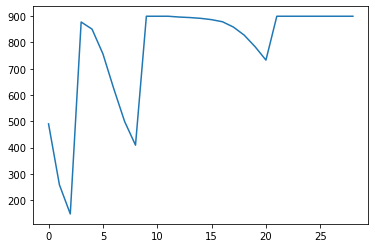

In [3]:
plt.plot(ranks)

In [4]:
pkl_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/nih/layer_embeddings/imgsize_128/nih_spurious_iterations/age_1p0_ep1-it840.pkl'
with open(pkl_path, 'rb') as handle:
    info_dict = pickle.load(handle)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.